## Simulating Adaptive Temperature Sensors

### **Overview**

This Jupyter Notebook explores an **adaptive temperature sensing approach** using gridded temperature data. The experiment evaluates the performance of an adaptive reporting mechanism compared to a traditional fixed-interval sensor system, considering data volume, reporting efficiency, and resource utilization.

### **Motivation**

In wildfire scenarios, sensor networks must operate efficiently to balance:
1. **Accuracy**: Maintaining sufficient temperature data resolution.
2. **Resource Efficiency**: Reducing energy consumption and bandwidth for data transmission.
3. **Scalability**: Ensuring the network adapts to environmental conditions without overwhelming resources.

To achieve this, we simulate **adaptive temperature sensors** that adjust their reporting granularity based on environmental thresholds:
- **Fine-grained reporting** for low to moderate temperatures.
- **Logarithmic scaling** for extreme temperatures, reducing unnecessary data points.

This experiment demonstrates how adaptive sensing can optimize sensor network performance.

---

### **Objectives**

1. **Simulate Adaptive Sensors**:
   - Place `n` temperature sensors randomly across a predefined temperature grid.
   - Extract hourly temperature data for each sensor from NetCDF datasets.
2. **Implement Adaptive Reporting**:
   - Dynamically adjust temperature reporting precision:
     - **< 20°C**: Report at 1°C intervals.
     - **20-30°C**: Report at 2°C intervals.
     - **> 30°C**: Use a logarithmic scale with 5°C intervals.
3. **Compare Against Fixed-Interval Sensors**:
   - Fixed-interval reporting assumes 1°C resolution at all temperatures.
4. **Evaluate Resource Efficiency**:
   - Measure data volume (bytes) for each reporting method.
   - Calculate resource efficiency as **distance-to-hub per byte transferred**.
5. **Visualize and Compare**:
   - Plot actual vs. reported temperatures for each sensor.
   - Compare efficiency gains between adaptive and fixed reporting systems.

---

### **Dataset**

- **Source**: ERA5 temperature grid data for Fort McMurray.
- **Format**: NetCDF (Climate Data Format).
- **Contents**:
  - Temperature data at a 2-meter height.
  - Grid resolution: 14x14 with hourly timestamps over 4 days.

---

### **Adaptive Reporting Logic**

The adaptive temperature reporting logic is implemented as follows:

| **Temperature Range** | **Reporting Granularity** |
|------------------------|---------------------------|
| `< 20°C`              | 1°C                      |
| `20°C to 30°C`        | 2°C                      |
| `> 30°C`              | Logarithmic (5°C steps)  |

This approach reduces redundant data transmission while maintaining sufficient precision at lower temperatures.

---

### **Experiment Workflow**

1. **Sensor Placement**:
   - Randomly place `n` sensors on the temperature grid.
2. **Data Extraction**:
   - Extract temperature readings at each sensor's location.
3. **Adaptive vs. Fixed Reporting**:
   - Simulate adaptive and fixed-interval reporting for each sensor.
4. **Efficiency Evaluation**:
   - Compute data volumes and resource efficiencies for both methods.
5. **Visualization**:
   - Compare actual vs. reported temperatures.
   - Plot efficiency gains between adaptive and fixed sensors.

---

### **Expected Results**

- **Data Reduction**: Adaptive reporting significantly reduces data volume compared to fixed-interval sensors.
- **Resource Efficiency**: Adaptive sensors demonstrate improved resource efficiency (distance per byte transmitted).
- **Visual Insights**: Plots highlight the trade-offs between accuracy and efficiency.

---

### **Code Execution**

To begin the experiment, execute the notebook cells sequentially. Modify the number of sensors (`n_sensors`) or adjust adaptive thresholds as needed to observe different behaviors.

--- 

Processing Sensor 1: (56.74999999999999, -111.75000000000001)


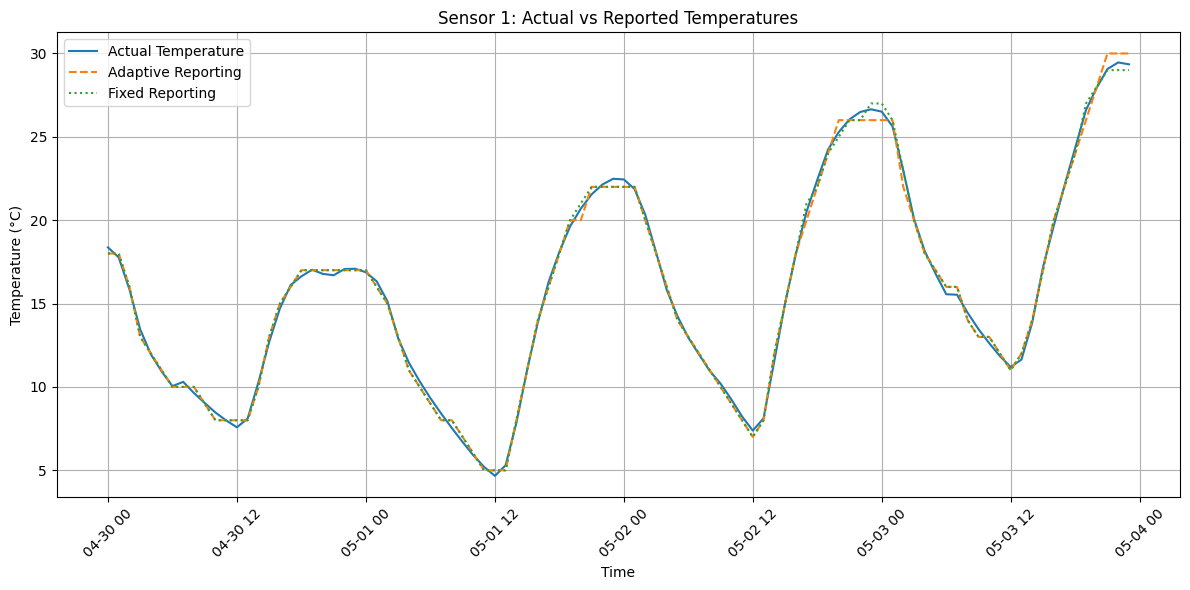

Processing Sensor 2: (56.149999999999984, -111.05000000000005)


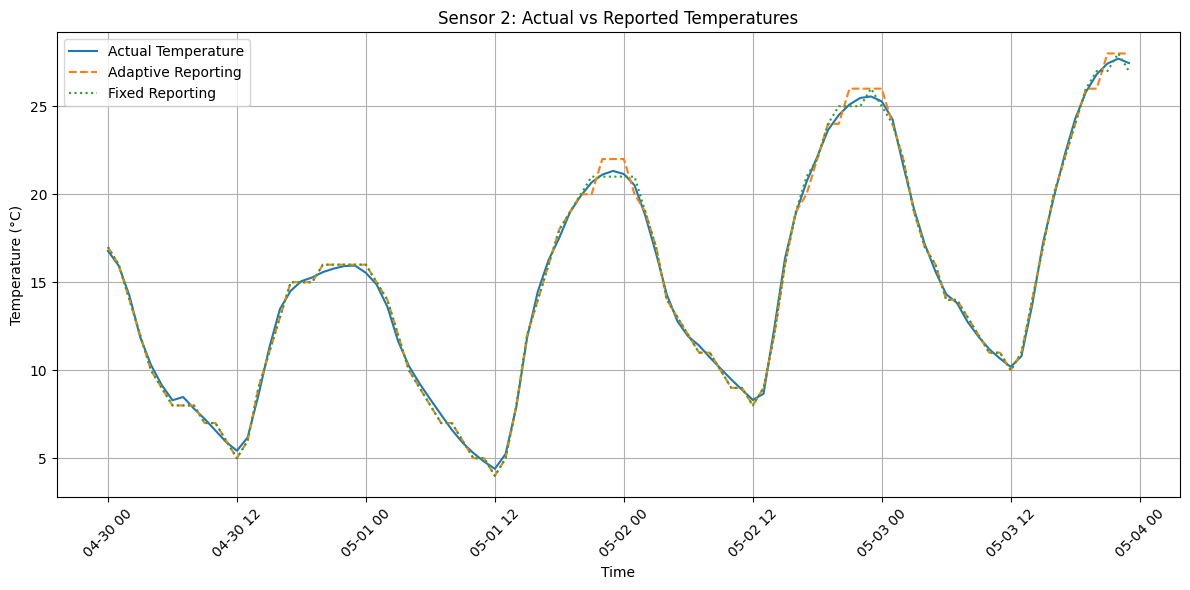

Processing Sensor 3: (56.64999999999999, -110.85000000000007)


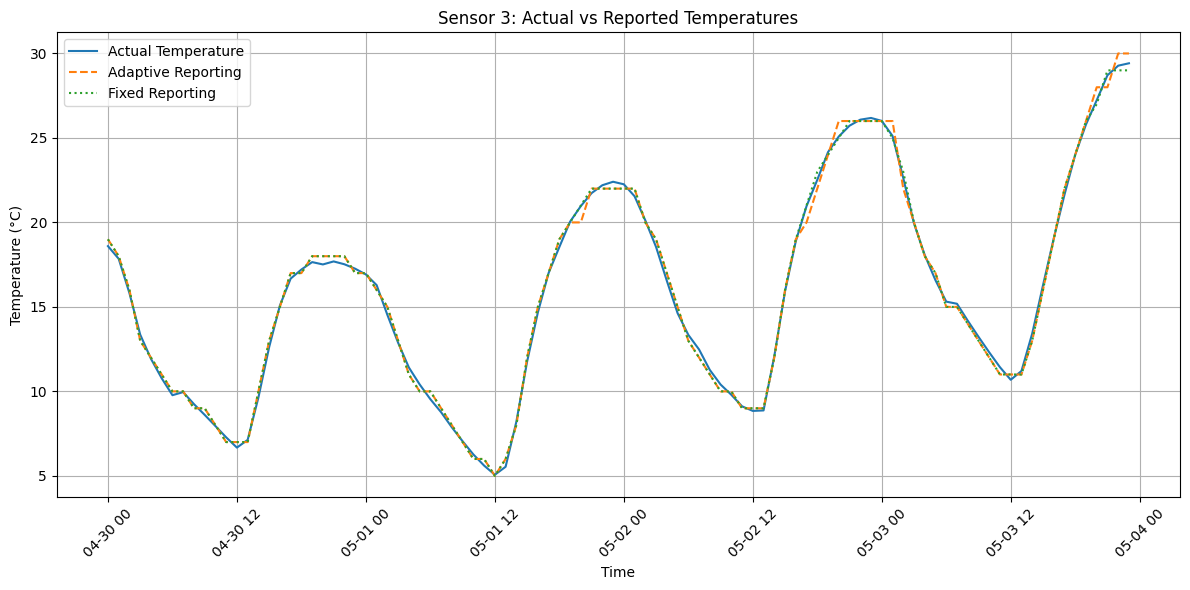

Processing Sensor 4: (56.949999999999996, -111.45000000000003)


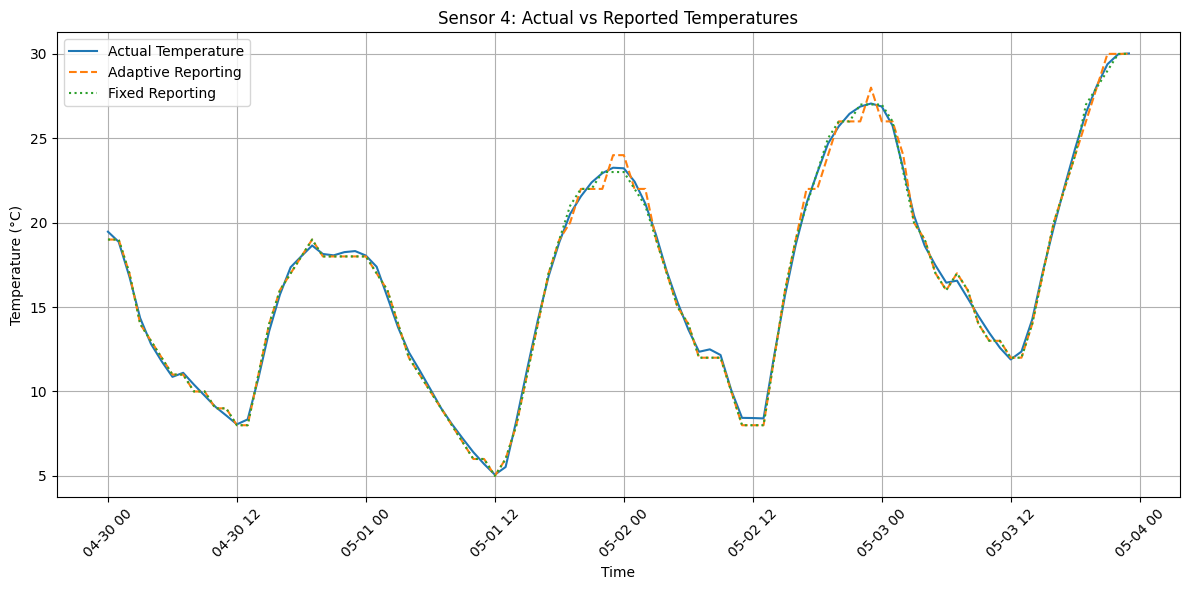

Processing Sensor 5: (56.44999999999999, -111.85000000000001)


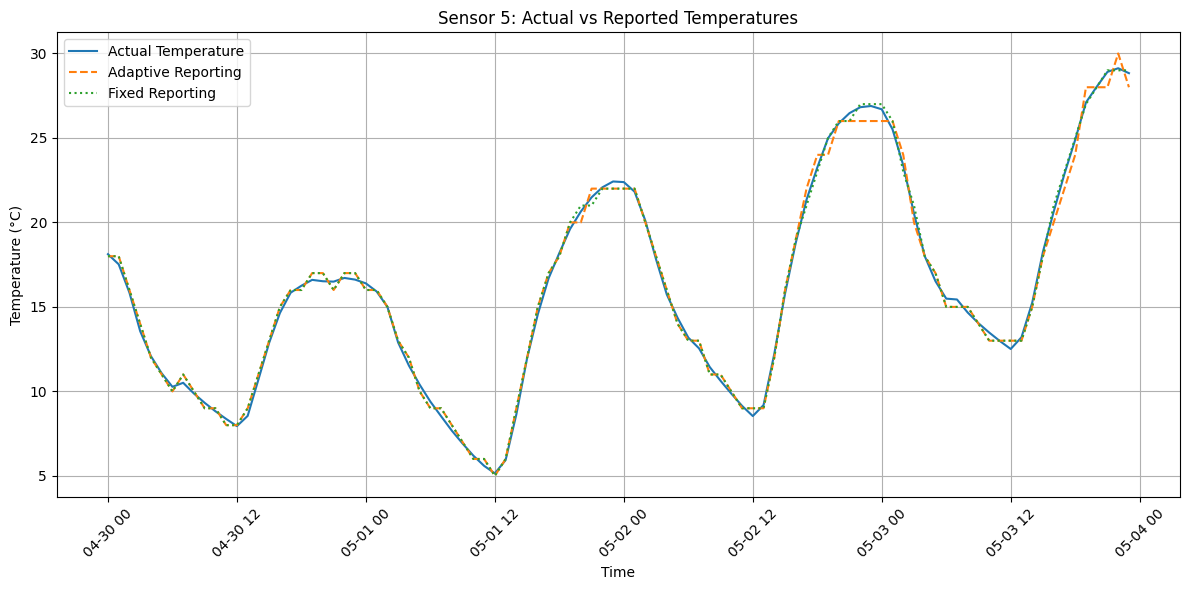


Sensor Network Summary Report:
   Sensor ID  Latitude  Longitude  Adaptive Volume (Bytes)  \
0          1     56.75    -111.75                       80   
1          2     56.15    -111.05                       84   
2          3     56.65    -110.85                       84   
3          4     56.95    -111.45                       84   
4          5     56.45    -111.85                       84   

   Fixed Volume (Bytes)  Efficiency Gain (%)  Distance to Hub (km)  \
0                    96                16.67                 22.06   
1                    96                12.50                 64.83   
2                    96                12.50                 34.06   
3                   104                19.23                 27.96   
4                    96                12.50                 39.15   

   Adaptive Efficiency (km/Byte)  Fixed Efficiency (km/Byte)  
0                       0.275809                    0.229841  
1                       0.771830                

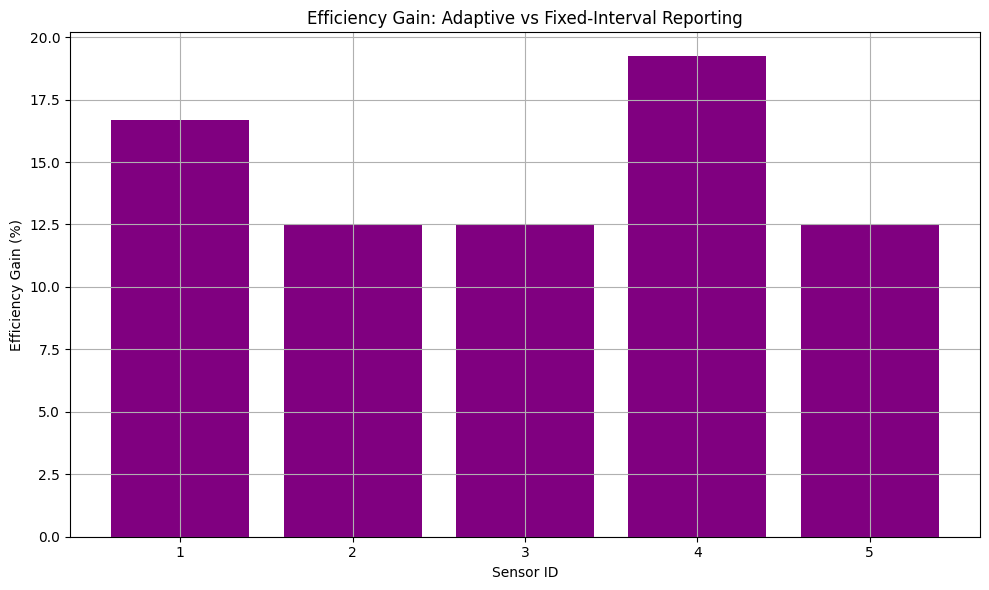

In [6]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import radians, cos, sin, sqrt, atan2

# Load the NetCDF data file
file_path = "../data/combined_era5_fort_mcmurray.nc"  # Adjust path as needed
ds = xr.open_dataset(file_path)

# Convert temperature to Celsius
ds["t2m_celsius"] = ds["t2m"] - 273.15

# Define the central hub location (average grid center)
central_lat, central_lon = ds["latitude"].mean().values, ds["longitude"].mean().values

# Haversine formula to compute distance between two latitude-longitude points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2.0) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2.0) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Adaptive reporting logic
def adaptive_reporting(temp):
    """Adaptive temperature reporting logic:
       - Fine granularity (1°C) below 20°C.
       - Coarser granularity (2°C) between 20°C and 30°C.
       - Logarithmic scale at extreme high temperatures (>30°C).
    """
    if temp < 20:
        return round(temp)  # Report to nearest 1°C
    elif 20 <= temp <= 30:
        return round(temp / 2) * 2  # Report to nearest 2°C
    elif temp > 30:
        return round(temp / 5) * 5  # Report to nearest 5°C
    else:
        return temp  # Fallback (unlikely)

# Function to simulate n sensors and analyze efficiency
def simulate_and_analyze_sensors(n_sensors):
    np.random.seed(42)  # Ensure repeatability
    
    # Randomly generate sensor locations
    latitudes = ds["latitude"].values
    longitudes = ds["longitude"].values
    sensor_locations = [(np.random.choice(latitudes), np.random.choice(longitudes)) for _ in range(n_sensors)]
    
    report_list = []
    
    # Simulate and analyze each sensor
    for idx, (sensor_lat, sensor_lon) in enumerate(sensor_locations):
        print(f"Processing Sensor {idx + 1}: ({sensor_lat}, {sensor_lon})")
        
        # Extract temperature data for the sensor
        sensor_data = ds["t2m_celsius"].sel(latitude=sensor_lat, longitude=sensor_lon)
        sensor_df = sensor_data.to_dataframe().reset_index()
        sensor_df = sensor_df[["valid_time", "t2m_celsius"]]
        
        # Adaptive reporting
        sensor_df["adaptive_temp"] = sensor_df["t2m_celsius"].apply(adaptive_reporting)
        
        # Fixed-interval reporting (traditional: 1°C precision)
        sensor_df["fixed_temp"] = sensor_df["t2m_celsius"].apply(lambda x: round(x))
        
        # Calculate data volumes
        adaptive_volume = sensor_df["adaptive_temp"].nunique() * 4  # Unique readings * 4 bytes
        fixed_volume = sensor_df["fixed_temp"].nunique() * 4       # Fixed-interval * 4 bytes
        
        # Calculate distance to hub and resource efficiency
        distance_to_hub = haversine(sensor_lat, sensor_lon, central_lat, central_lon)
        adaptive_efficiency = distance_to_hub / adaptive_volume if adaptive_volume > 0 else 0
        fixed_efficiency = distance_to_hub / fixed_volume if fixed_volume > 0 else 0
        
        # Append results to the summary report
        report_list.append({
            "Sensor ID": idx + 1,
            "Latitude": sensor_lat,
            "Longitude": sensor_lon,
            "Adaptive Volume (Bytes)": adaptive_volume,
            "Fixed Volume (Bytes)": fixed_volume,
            "Efficiency Gain (%)": round((fixed_volume - adaptive_volume) / fixed_volume * 100, 2),
            "Distance to Hub (km)": round(distance_to_hub, 2),
            "Adaptive Efficiency (km/Byte)": round(adaptive_efficiency, 6),
            "Fixed Efficiency (km/Byte)": round(fixed_efficiency, 6)
        })
        
        # Plot Actual vs Reported Temperatures
        plt.figure(figsize=(12, 6))
        plt.plot(sensor_df["valid_time"], sensor_df["t2m_celsius"], label="Actual Temperature", color="tab:blue")
        plt.plot(sensor_df["valid_time"], sensor_df["adaptive_temp"], label="Adaptive Reporting", color="tab:orange", linestyle="--")
        plt.plot(sensor_df["valid_time"], sensor_df["fixed_temp"], label="Fixed Reporting", color="tab:green", linestyle=":")
        plt.title(f"Sensor {idx + 1}: Actual vs Reported Temperatures")
        plt.xlabel("Time")
        plt.ylabel("Temperature (°C)")
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()
        plt.tight_layout()
        plt.show()
    
    # Summarize results
    report_df = pd.DataFrame(report_list)
    print("\nSensor Network Summary Report:")
    print(report_df)
    
    # Plot efficiency comparison
    plt.figure(figsize=(10, 6))
    plt.bar(report_df["Sensor ID"], report_df["Efficiency Gain (%)"], color="purple")
    plt.title("Efficiency Gain: Adaptive vs Fixed-Interval Reporting")
    plt.xlabel("Sensor ID")
    plt.ylabel("Efficiency Gain (%)")
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    return report_df

# Run the simulation with n sensors
n_sensors = 5
report_df = simulate_and_analyze_sensors(n_sensors)
